In [1]:
# https://github.com/MaybeRichard/KAN-Layer/blob/main/KAN.py
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=20, #was 5
        spline_order=5, #Was 3
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.03,
        grid_range=[-4, 4], #Was -1,1
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [2]:
# pip install tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

# Define hyperparameters
batch_size = 64 #Was 64
epochs = 10  # It was 10
lr = 0.001  # It was 0.001

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize KAN model
model = KAN([784, 256, 128, 10]).to(device)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count trainable parameters
num_trainable_params = count_parameters(model)

print(f"Number of trainable parameters: {num_trainable_params}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainacckan = []
testacckan = []
trainlosskan = []
testlosskan = []
# Train model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar for training loop
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(-1, 784)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=correct / total)

    # Print training loss and accuracy
    train_loss = running_loss / len(train_loader)
    trainlosskan.append(train_loss)
    train_acc = correct / total
    trainacckan.append(train_acc)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')

    # Evaluate model on test set
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Progress bar for test loop
    with tqdm(test_loader, unit="batch", desc="Test") as tepoch_test:
        with torch.no_grad():
            for inputs, labels in tepoch_test:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)

                test_loss += loss.item()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Update test progress bar with loss and accuracy
                tepoch_test.set_postfix(loss=test_loss / (tepoch_test.n + 1), accuracy=correct / total)

    # Print test loss and accuracy
    test_loss /= len(test_loader)
    testlosskan.append(test_loss)
    test_acc = correct / total
    testacckan.append(test_acc)
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}\n')

    def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

# @misc{yu2024kanbefair,
#       title={KAN or MLP: A Fairer Comparison},
#       author={Runpeng Yu and Weihao Yu and Xinchao Wang},
#       year={2024},
#       eprint={2407.16674},
#       archivePrefix={arXiv},
#       primaryClass={cs.LG},
#       url={https://arxiv.org/abs/2407.16674},
# }

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 11617977.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 347452.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3203983.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2889070.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of trainable parameters: 6338304


Epoch 1: 100%|██████████| 938/938 [00:28<00:00, 32.99batch/s, accuracy=0.914, loss=0.288]


Epoch 1, Training Loss: 0.2870, Training Accuracy: 0.9138


Test: 100%|██████████| 157/157 [00:02<00:00, 56.66batch/s, accuracy=0.96, loss=0.129]


Epoch 1, Test Loss: 0.1267, Test Accuracy: 0.9599



Epoch 2: 100%|██████████| 938/938 [00:23<00:00, 40.36batch/s, accuracy=0.971, loss=0.0937]


Epoch 2, Training Loss: 0.0935, Training Accuracy: 0.9706


Test: 100%|██████████| 157/157 [00:02<00:00, 67.44batch/s, accuracy=0.973, loss=0.0901]


Epoch 2, Test Loss: 0.0866, Test Accuracy: 0.9730



Epoch 3: 100%|██████████| 938/938 [00:22<00:00, 42.10batch/s, accuracy=0.983, loss=0.0557]


Epoch 3, Training Loss: 0.0556, Training Accuracy: 0.9825


Test: 100%|██████████| 157/157 [00:02<00:00, 68.45batch/s, accuracy=0.975, loss=0.0792]


Epoch 3, Test Loss: 0.0777, Test Accuracy: 0.9749



Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, accuracy=0.989, loss=0.0377]


Epoch 4, Training Loss: 0.0376, Training Accuracy: 0.9885


Test: 100%|██████████| 157/157 [00:02<00:00, 68.75batch/s, accuracy=0.978, loss=0.0758]


Epoch 4, Test Loss: 0.0749, Test Accuracy: 0.9775



Epoch 5: 100%|██████████| 938/938 [00:21<00:00, 44.10batch/s, accuracy=0.991, loss=0.0273]


Epoch 5, Training Loss: 0.0272, Training Accuracy: 0.9909


Test: 100%|██████████| 157/157 [00:02<00:00, 68.50batch/s, accuracy=0.98, loss=0.0686]


Epoch 5, Test Loss: 0.0673, Test Accuracy: 0.9796



Epoch 6: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, accuracy=0.992, loss=0.0219]


Epoch 6, Training Loss: 0.0219, Training Accuracy: 0.9924


Test: 100%|██████████| 157/157 [00:02<00:00, 68.62batch/s, accuracy=0.978, loss=0.0831]


Epoch 6, Test Loss: 0.0820, Test Accuracy: 0.9777



Epoch 7: 100%|██████████| 938/938 [00:21<00:00, 44.28batch/s, accuracy=0.994, loss=0.0184]


Epoch 7, Training Loss: 0.0184, Training Accuracy: 0.9938


Test: 100%|██████████| 157/157 [00:02<00:00, 68.01batch/s, accuracy=0.98, loss=0.0691]


Epoch 7, Test Loss: 0.0674, Test Accuracy: 0.9803



Epoch 8: 100%|██████████| 938/938 [00:21<00:00, 44.55batch/s, accuracy=0.993, loss=0.0187]


Epoch 8, Training Loss: 0.0186, Training Accuracy: 0.9935


Test: 100%|██████████| 157/157 [00:02<00:00, 68.17batch/s, accuracy=0.98, loss=0.0814]


Epoch 8, Test Loss: 0.0783, Test Accuracy: 0.9802



Epoch 9: 100%|██████████| 938/938 [00:21<00:00, 44.58batch/s, accuracy=0.995, loss=0.0156]


Epoch 9, Training Loss: 0.0155, Training Accuracy: 0.9947


Test: 100%|██████████| 157/157 [00:02<00:00, 62.13batch/s, accuracy=0.978, loss=0.0911]


Epoch 9, Test Loss: 0.0905, Test Accuracy: 0.9776



Epoch 10: 100%|██████████| 938/938 [00:20<00:00, 45.31batch/s, accuracy=0.995, loss=0.015]


Epoch 10, Training Loss: 0.0150, Training Accuracy: 0.9947


Test: 100%|██████████| 157/157 [00:02<00:00, 57.38batch/s, accuracy=0.979, loss=0.0862]

Epoch 10, Test Loss: 0.0840, Test Accuracy: 0.9794



In [4]:
trainacckan, testacckan, testlosskan, trainlosskan

([0.9138,
  0.97055,
  0.9825333333333334,
  0.9885333333333334,
  0.9909333333333333,
  0.9923666666666666,
  0.9938333333333333,
  0.9934833333333334,
  0.99465,
  0.9947166666666667],
 [0.9599,
  0.973,
  0.9749,
  0.9775,
  0.9796,
  0.9777,
  0.9803,
  0.9802,
  0.9776,
  0.9794],
 [0.12665166575342987,
  0.0866164218320713,
  0.0776606183608469,
  0.0748538126212294,
  0.06727281605560113,
  0.08201655124759354,
  0.06735070706675687,
  0.07828862446499471,
  0.09053907756946686,
  0.08402587363237037],
 [0.286968083718597,
  0.09352449937336353,
  0.05561728645111126,
  0.037569388316180716,
  0.027203802613472976,
  0.021901933495038457,
  0.018435675731685044,
  0.018611890067862256,
  0.015529682767488933,
  0.014951107559469157])

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define hyperparameters
input_shape = 784  # Same as your PyTorch model (28x28 flattened)
hidden_units = 7000  # Same as the first hidden layer in your KAN model
output_units = 10  # For 10 classes in MNIST dataset (0-9)

# Creating lists to store train and test accuracies
trainaccmlp = []
testaccmlp = []

# Custom callback to save training and test accuracies after each epoch
class LossAccuracyHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LossAccuracyHistory, self).__init__()
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs['loss'])  # Append training loss
        self.test_losses.append(logs['val_loss'])  # Append test loss
        self.train_accuracies.append(logs['accuracy'])  # Append training accuracy
        self.test_accuracies.append(logs['val_accuracy'])  # Append test accuracy

# Build the MLP model
model = models.Sequential()

# Input Layer
model.add(layers.InputLayer(input_shape=(input_shape,)))

# Hidden Layer (match the 256 hidden units of KAN)
model.add(layers.Dense(256, activation='swish'))  # Swish is equivalent to SiLU

# Hidden Layer (match the 128 hidden units of KAN)
model.add(layers.Dense(128, activation='swish'))  # Swish is equivalent to SiLU

# Output Layer
model.add(layers.Dense(output_units, activation='softmax'))  # Softmax for multiclass classification

# Compile the model (Adam optimizer and cross-entropy loss)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary to check the number of parameters
model.summary()

# Prepare the MNIST dataset (same preprocessing as PyTorch)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1, 784)).astype('float32') / 255
test_images = test_images.reshape((-1, 784)).astype('float32') / 255

# Instantiate the modified callback
history_callback = LossAccuracyHistory()

# Train the model with the callback
history = model.fit(train_images, train_labels, epochs=10, batch_size=64,
                    validation_data=(test_images, test_labels), callbacks=[history_callback])

# Access the stored losses and accuracies
trainlossmlp = history_callback.train_losses
testlossmlp = history_callback.test_losses
trainaccmlp = history_callback.train_accuracies
testaccmlp = history_callback.test_accuracies

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8880 - loss: 0.3520 - val_accuracy: 0.9528 - val_loss: 0.1576
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9577 - loss: 0.1451 - val_accuracy: 0.9585 - val_loss: 0.1517
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9660 - loss: 0.1222 - val_accuracy: 0.9589 - val_loss: 0.1562
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9687 - loss: 0.1134 - val_accuracy: 0.9641 - val_loss: 0.1371
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9736 - loss: 0.1008 - val_accuracy: 0.9643 - val_loss: 0.1416
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9749 - loss: 0.0938 - val_accuracy: 0.9706 - val_loss: 0.1238
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9772 - loss: 0.0886 - val_accuracy: 0.9648 - val_loss: 0.1625
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

In [6]:
trainaccmlp, testaccmlp, trainlossmlp, testlossmlp

([0.9285666942596436,
  0.9585166573524475,
  0.9641500115394592,
  0.9693499803543091,
  0.9714333415031433,
  0.9746333360671997,
  0.9744333624839783,
  0.9779166579246521,
  0.9794166684150696,
  0.9794833064079285],
 [0.9527999758720398,
  0.9585000276565552,
  0.958899974822998,
  0.9641000032424927,
  0.9642999768257141,
  0.9706000089645386,
  0.9648000001907349,
  0.9563999772071838,
  0.9682999849319458,
  0.9693999886512756],
 [0.23649194836616516,
  0.14712490141391754,
  0.13132211565971375,
  0.11384733766317368,
  0.10975150763988495,
  0.09594178199768066,
  0.09908050298690796,
  0.08427775651216507,
  0.08341909199953079,
  0.08155153691768646],
 [0.1576252281665802,
  0.1516622006893158,
  0.15623681247234344,
  0.1371433585882187,
  0.1416013240814209,
  0.12381307035684586,
  0.16248305141925812,
  0.17897631227970123,
  0.18019700050354004,
  0.14334629476070404])

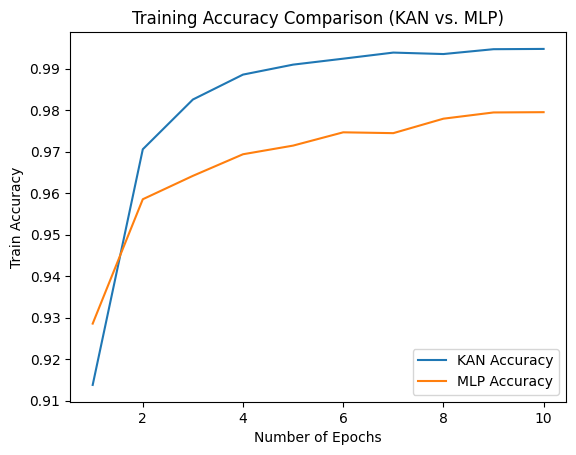

In [15]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,11)], trainacckan, label='KAN Accuracy')
plt.plot([i for i in range(1,11)], trainaccmlp, label='MLP Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy Comparison (KAN vs. MLP)')
plt.legend()

plt.show()

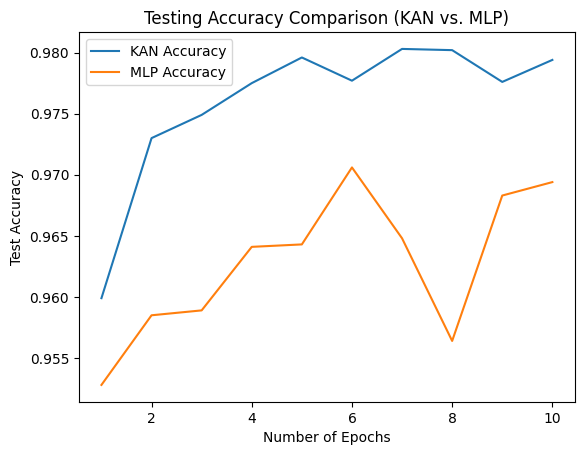

In [14]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,11)], testacckan, label='KAN Accuracy')
plt.plot([i for i in range(1,11)], testaccmlp, label='MLP Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.title('Testing Accuracy Comparison (KAN vs. MLP)')
plt.legend()


plt.show()

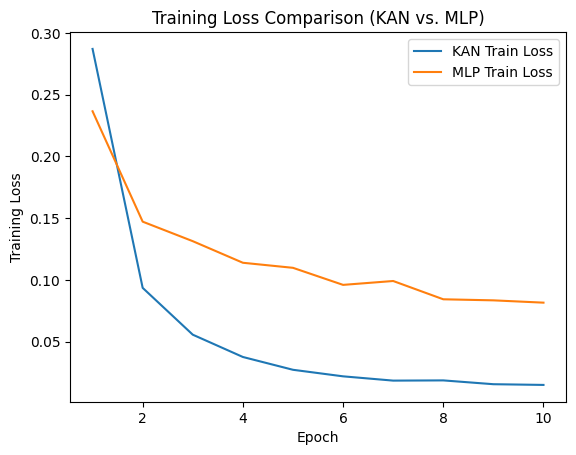

In [12]:
import matplotlib.pyplot as plt

# Assuming trainlossmlp and trainlosskan are lists containing the losses
# and have at least 10 elements

epochs = range(1, 11)  # Epochs 1 to 10

plt.plot(epochs, trainlosskan[:10], label='KAN Train Loss')
plt.plot(epochs, history_callback.train_losses[:10], label='MLP Train Loss')  # Accessing from callback

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison (KAN vs. MLP)')
plt.legend()

plt.show()

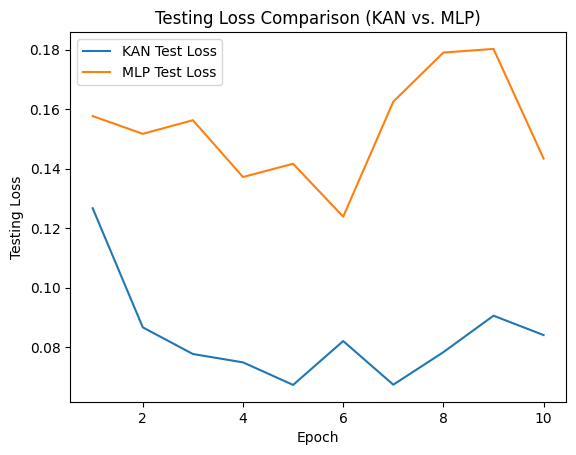

In [13]:
import matplotlib.pyplot as plt

# Assuming testlossmlp and testlosskan are lists containing the losses
# and have at least 10 elements

epochs = range(1, 11)  # Epochs 1 to 10

plt.plot(epochs, testlosskan[:10], label='KAN Test Loss')
plt.plot(epochs, history_callback.test_losses[:10], label='MLP Test Loss')  # Accessing from callback

plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.title('Testing Loss Comparison (KAN vs. MLP)')
plt.legend()
plt.show()